In [11]:
%pip install feature_engine
%pip install sktime
%pip install darts

Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/8e/a8/dbfff16296f7fe220cc2ab9bcabc525a943c2625e4d379b2ce6a42f7f434/sktime-0.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a9/28/2babef91a7c2f84718d8c47ecd89216913cf9e130d302208c3cfd0d17122/numba-0.56.4-cp37-cp37m-macosx_10_14_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/31/a5f5f578a2b19938e1bb91dcd79bd436557baf582dde23845cb0e76a2241/llvmlite-0.39.1-cp37-cp37m-macosx_10_9_x86_64.whl
  Found existing installation: llvmlite 0.29.0
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Note: you may need to restart the kernel to use updated packages.
  Using cached https://files.pythonhosted.org/packages/e7/ad/1df46bf1dffc5d4bba60ec98e63d4c1ad3cdd7e274c74a44dfdbdd60266b/darts-0.22.0-py3-none

## Import Packages

In [12]:
import os
import dataframe
import pickle

# dataframe packages
import pandas as pd
import numpy as np

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# sklearn metrics
from sklearn.metrics import (   r2_score, 
                                mean_absolute_error, 
                                mean_absolute_percentage_error, 
                                mean_squared_error)

#pipeline & Custom pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

#feature engine packages
from feature_engine.creation import CyclicalFeatures

import warnings
warnings.filterwarnings('ignore')

import datetime
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [13]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## getInputInfo

In [14]:
# Sales Data: Training Set (1-1913) + Validation Set (1914-1941)
sales = pd.read_csv('sales_train_evaluation.csv')
sales.name = 'sales'

print("{:,} records for training data".format(len(sales)))

# Calendar
calendar = pd.read_csv('calendar.csv')
calendar.name = 'calendar'
print("{:,} records for calendar data".format(len(calendar)))

# Pricing
prices = pd.read_csv('sell_prices.csv')
prices.name = 'prices'
print("{:,} records for price data".format(len(prices)))

30,490 records for training data
1,969 records for calendar data
6,841,121 records for price data


## downcasting - reduce memory

In [15]:
%time
def reduce_mem_usage(df, display = False):
    '''
    reduce memory usage by downcasting data types
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns
    categorical_columns = df.select_dtypes(include = ["object"]).columns
    '''
    As pandas stores categorical features as "object" we can instead use "category" datatype
    by which we can reduce little bit of memory usage
    '''
    
    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
        
    for col in categorical_columns:
        df[col] = df[col].astype("category")
    

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if display:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 19.1 µs


In [16]:
%time
sales = reduce_mem_usage(df = sales, display = True)
calendar = reduce_mem_usage(df = calendar, display = True)
prices = reduce_mem_usage(df = prices, display = True)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs
Mem. usage decreased to 95.77 Mb (78.9% reduction)
Mem. usage decreased to  0.19 Mb (8.7% reduction)
Mem. usage decreased to 58.80 Mb (71.8% reduction)


### Additional Features: Pricing

-> Relative difference between the current price of an item and its historical average price, to highlight promotional offers’ impact.

-> Price relative difference with the same item sold in other stores, to understand whether or not the store has an attractive price.

-> Price relative difference with other items sold in the same store and same product category, to capture some cannibalization effects.

In [17]:
def get_improve_price():
    # Calculate Average price across all stores
    df_mean_store = pd.DataFrame(prices.groupby(['item_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_store.columns = ['item_sells_price_avg']
    df_mean_store.reset_index(inplace = True)

    # Combine with calendar
    prices_new = pd.merge(prices, df_mean_store, on=['item_id', 'wm_yr_wk'], how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # Price difference with same items in other stores
    prices_new['delta_price_all_rel'] = (prices_new['sell_price'] - 
                                         prices_new['item_sells_price_avg'])/prices_new['item_sells_price_avg']

    # Price difference with last week
    prices_new['item_store'] = prices_new['item_id'].astype(str) + '_' + prices_new['store_id'].astype(str)
    prices_new['item_store_change'] = prices_new["item_store"].shift() != prices_new["item_store"]
    # Price difference week n - week n-1
    prices_new['delta_price_weekn-1'] = (prices_new['sell_price']-
                                         prices_new['sell_price'].shift(1)).fillna(0)/prices_new['sell_price'].shift(1)
    prices_new['delta_price_weekn-1'] = prices_new['delta_price_weekn-1'].fillna(0) * (prices_new['item_store_change']==0)

    # Average price of the department by store
    prices_new['dept_id'] = prices_new.item_id.str[:-4]
    df_mean_cat = pd.DataFrame(prices_new.groupby(['dept_id', 'store_id', 'wm_yr_wk'])['sell_price'].mean())
    df_mean_cat.columns = ['dept_sells_price_avg']
    df_mean_cat.reset_index(inplace = True)
    # Combine with price dataset
    prices_new = pd.merge(prices_new, df_mean_cat, on=['dept_id', 'store_id', 'wm_yr_wk']
                          , how='left', suffixes=('', '_y'))
    prices_new.drop(prices_new.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    # Cannibalisation: compare this item price with average of the department (category)
    prices_new['delta_price_cat_rel'] = (prices_new['sell_price'] - 
                                         prices_new['dept_sells_price_avg'])/prices_new['dept_sells_price_avg']                                               

    # Drop columns
    prices_new.drop(['item_sells_price_avg', 'item_store_change', 'item_store_change', 'dept_id', 'item_store',
                    'dept_sells_price_avg'], axis = 1, inplace = True)
    return prices_new

In [18]:
%time
prices_improved = get_improve_price()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.3 µs


### 2. Melt Data to reconstitute sales records

Convert from wide to long format (records on row level

In [19]:
# Melt
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
             var_name='d', value_name='sold').dropna()
print("{:,} records to combine with calendar and price".format(len(df)))
df.head()

59,181,090 records to combine with calendar and price


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [20]:
# Combine with calendar
df = pd.merge(df, calendar, on='d', how='left')
# Combine with price
df = pd.merge(df, prices_improved, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [10]:
print("{:,} records in df".format(len(df)))
df.head()

59,181,090 records in df


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN


## 3. Explorative Data Analysis

In [99]:
item_counts = df.groupby(['store_id', 'cat_id',"dept_id"]).agg({'item_id':'nunique'}).reset_index()
item_counts.columns = ['store_id', 'cat_id','dept_id', 'item_counts']

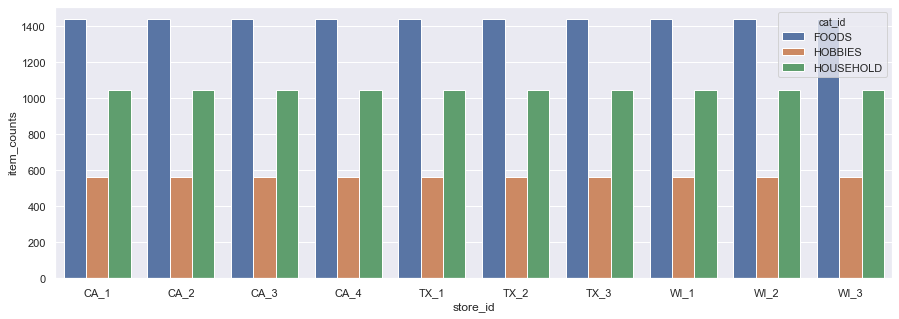

In [95]:
plt.figure(figsize = (15,5))
dummy = pd.pivot_table(data = item_counts, values = "item_counts", 
               index = ["store_id","cat_id"],aggfunc = 'sum').reset_index()

sns.barplot(data=dummy, x='store_id', y='item_counts', hue = "cat_id",errwidth=0)
plt.show()

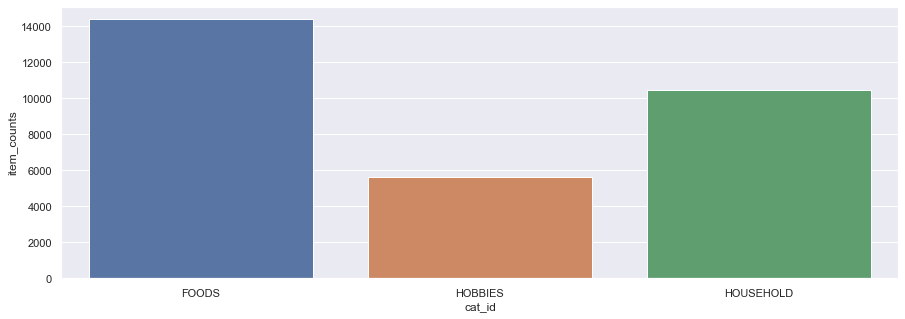

In [96]:
plt.figure(figsize = (15,5))
dummy = pd.pivot_table(data = item_counts, values = "item_counts", 
               index = "cat_id",aggfunc = 'sum').reset_index()

sns.barplot(data=dummy, x='cat_id', y='item_counts',errwidth=0)
plt.show()

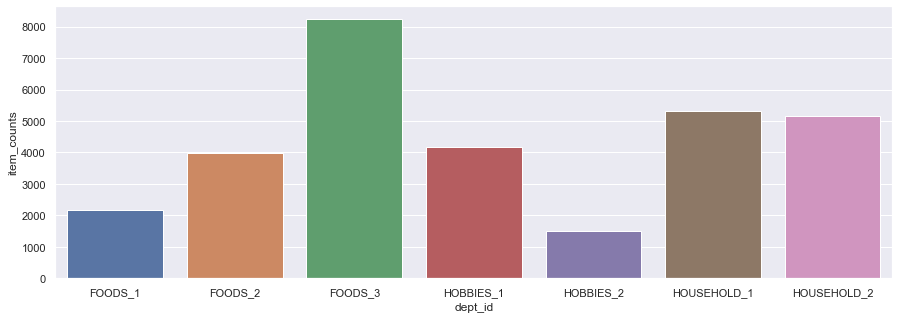

In [97]:
plt.figure(figsize = (15,5))
dummy = pd.pivot_table(data = item_counts, values = "item_counts", 
               index = "dept_id",aggfunc = 'sum').reset_index()

sns.barplot(data=dummy, x='dept_id', y='item_counts',errwidth=0)
plt.show()

#### Sales dispersion across category - store level

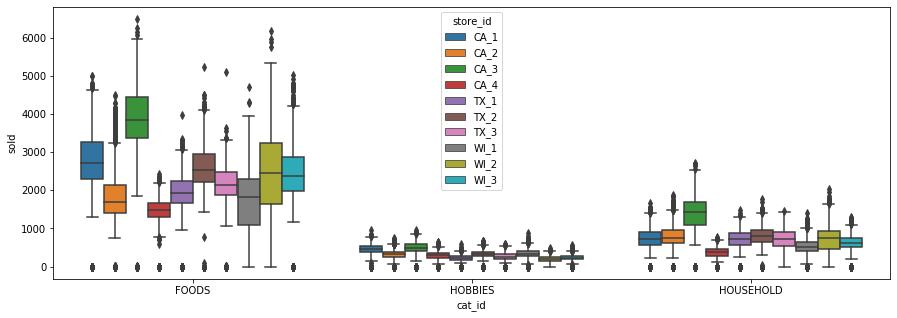

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

df_grouped_category = df.groupby(["cat_id","store_id","date"]).agg({"sold":sum})
df_grouped_category = df_grouped_category.reset_index()

sns.boxplot(data=df_grouped_category, x='cat_id', y='sold', hue='store_id', order=['FOODS', 'HOBBIES', 'HOUSEHOLD'], ax=ax);

#### Price dispersion across category - store level

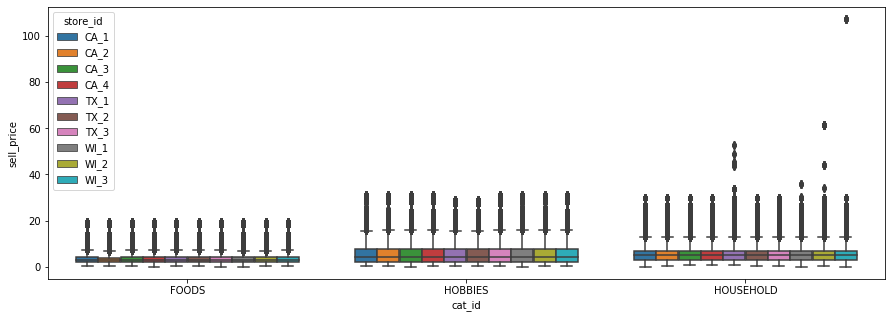

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.boxplot(data=df, x='cat_id', y='sell_price', hue='store_id', order=['FOODS', 'HOBBIES', 'HOUSEHOLD'], ax=ax);

### Time Series Charts

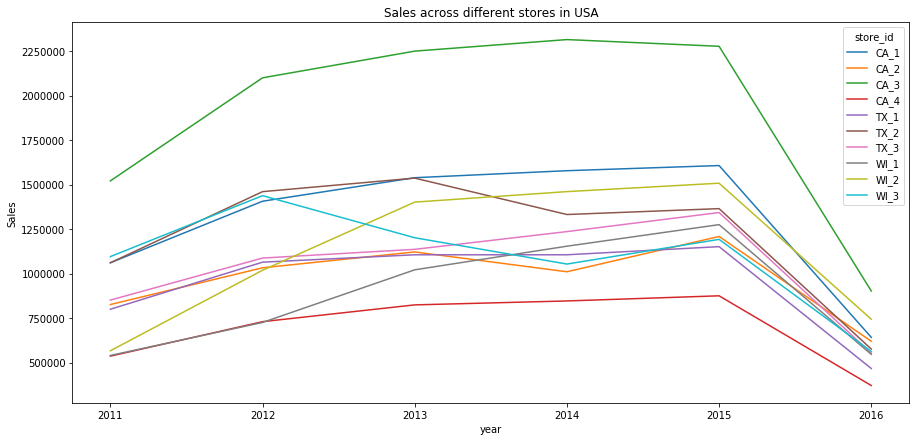

In [50]:
pd.pivot_table(df, values = "sold", 
               index = ["year"], columns = ["store_id"], aggfunc = sum).\
                plot(figsize = (15,7))
plt.ylabel("Sales")
plt.title("Sales across different stores in USA")
plt.show()

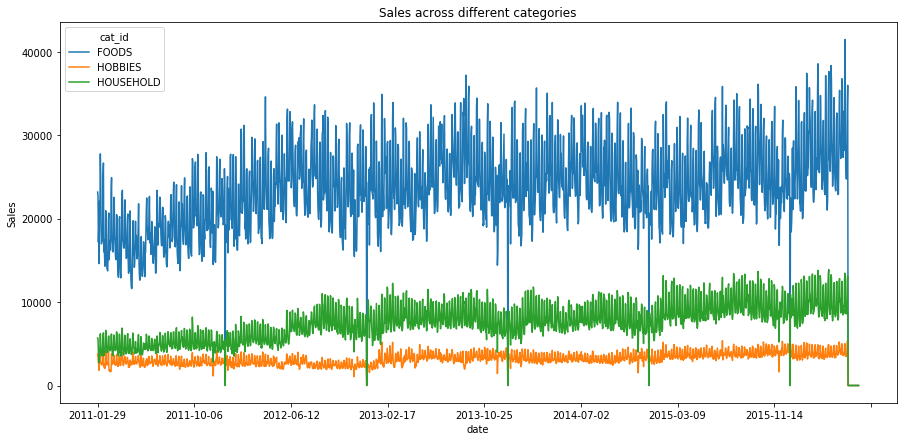

In [47]:
pd.pivot_table(df, values = "sold", 
               index = ["date"], columns = ["cat_id"], aggfunc = sum).\
                plot(kind = 'line',figsize = (15,7))
plt.ylabel("Sales")
plt.title("Sales across different categories")
plt.show()

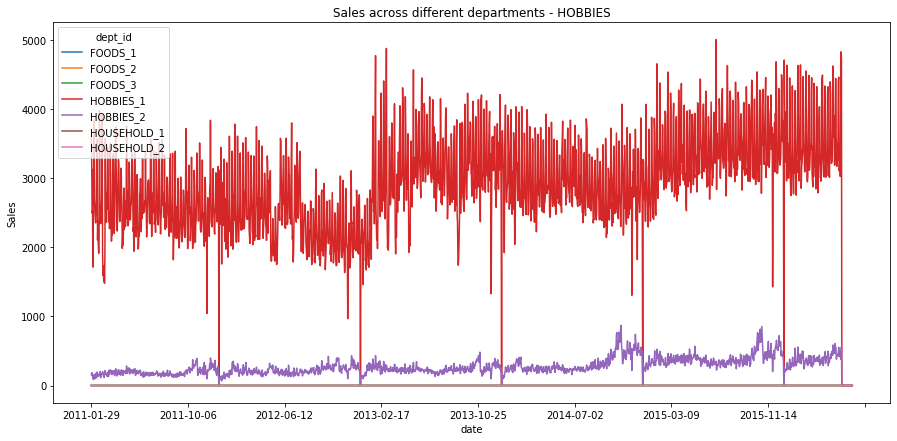

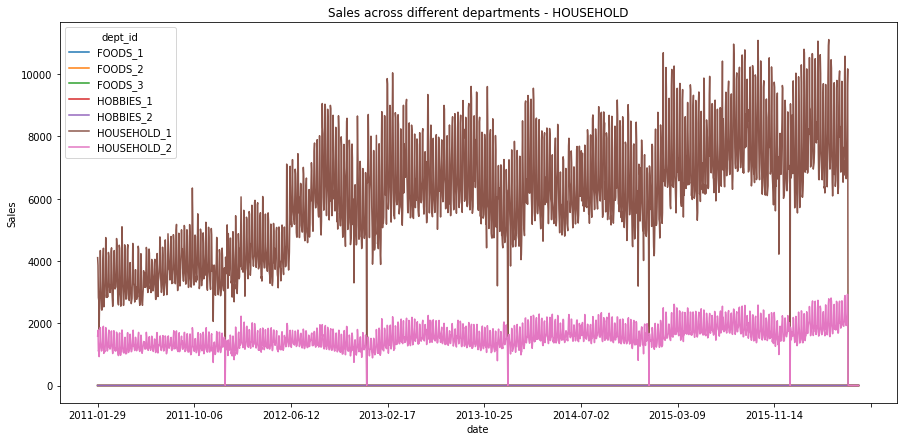

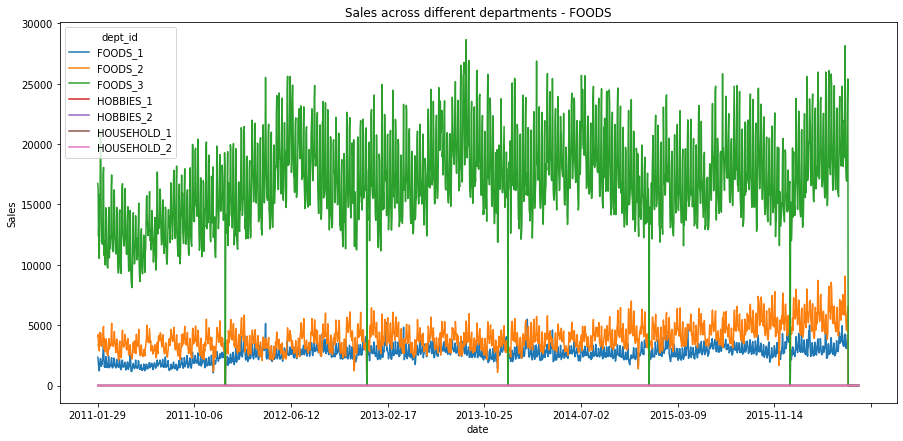

In [55]:
for i in ["HOBBIES","HOUSEHOLD","FOODS"]:
    df_ind_cat =df[df["cat_id"]== i]
    pd.pivot_table(df_ind_cat, values = "sold", 
                   index = ["date"], columns = ["dept_id"], aggfunc = sum).\
                    plot(figsize = (15,7))
    plt.ylabel("Sales")
    plt.title("Sales across different departments - "+str(i))
    plt.show()

In [102]:
del item_counts, df_ind_cat, df_grouped_category, dummy

## 4.Label Encoding

In [103]:
# Change Store id to category type
df.date = df.date.astype("datetime64[ns]")
df.year = df.year.astype("category")
df.store_id = df.store_id.astype('category')
df.item_id = df.item_id.astype('category')
df.cat_id = df.cat_id.astype('category')
df.state_id = df.state_id.astype('category')
df.id = df.id.astype('category')
df.dept_id = df.dept_id.astype('category')

# Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))

# Item, Department and Categories
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))

# Stores and States
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [104]:
# Save to DataFrame
LIST_SAVE = [d_id, d_item_id, d_dept_id, d_cat_id, d_store_id, d_state_id]
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
for list_save, list_name in zip(LIST_SAVE, LIST_NAME):
    pickle.dump(list_save, open('{}.json'.format(list_name), "wb"))  

In [110]:
# Mapping with Category Codes
# Remove d_ and transform to int (dates)
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()

# Transform categorical data to codes
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
print("Dataframe shape: {}".format(df.shape))
df.head()

Dataframe shape: (59181090, 25)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel
0,14370,1437,3,1,0,0,1,0,2011-01-29,11101,2,1,1,0,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,2011-01-29,11101,2,1,1,0,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,2011-01-29,11101,2,1,1,0,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,2011-01-29,11101,2,1,1,0,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,2011-01-29,11101,2,1,1,0,-1,-1,-1,-1,0,0,0,NaN,NaN,NaN,NaN


## 5. Data Cleaning

In [131]:
df[df["id"].isin([14370,14371])].groupby("id").agg({'date':[min,max]})

date           
             min        max
id                         
14370 2011-01-29 2016-05-22
14371 2011-01-29 2016-05-22

### Items having zero sales across portfolio?

In [121]:
item_sales = df.groupby("id").apply(lambda x : x["sold"].sum()).reset_index().\
                                                rename(columns = {0:"SM_OF_SAL"})
print("Shape of items having zero sales: ", item_sales[item_sales["SM_OF_SAL"]<=0].shape[0])
del item_sales

Shape of items having zero sales:  0


### Null Count percentage

In [147]:
df.isnull().sum()/df.shape[0]

id                     0.000000
item_id                0.000000
dept_id                0.000000
cat_id                 0.000000
store_id               0.000000
state_id               0.000000
d                      0.000000
sold                   0.000000
date                   0.000000
wm_yr_wk               0.000000
weekday                0.000000
wday                   0.000000
month                  0.000000
year                   0.000000
event_name_1           0.000000
event_type_1           0.000000
event_name_2           0.000000
event_type_2           0.000000
snap_CA                0.000000
snap_TX                0.000000
snap_WI                0.000000
sell_price             0.207827
delta_price_all_rel    0.207827
delta_price_weekn-1    0.207827
delta_price_cat_rel    0.207827
sales_cumsum           0.000000
dtype: float64

### Drop first zero occurance records with respect each product

In [148]:
%time 
df = df.sort_values(["id","date"], ascending = True)
df["sales_cumsum"] = df.groupby("id")["sold"].transform("cumsum").astype(np.float16)
df = df[df["sales_cumsum"]>0]
df = df.sort_values(["id","date"], ascending = True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 28.4 µs


In [149]:
df.isnull().sum()/df.shape[0]

id                     0.0
item_id                0.0
dept_id                0.0
cat_id                 0.0
store_id               0.0
state_id               0.0
d                      0.0
sold                   0.0
date                   0.0
wm_yr_wk               0.0
weekday                0.0
wday                   0.0
month                  0.0
year                   0.0
event_name_1           0.0
event_type_1           0.0
event_name_2           0.0
event_type_2           0.0
snap_CA                0.0
snap_TX                0.0
snap_WI                0.0
sell_price             0.0
delta_price_all_rel    0.0
delta_price_weekn-1    0.0
delta_price_cat_rel    0.0
sales_cumsum           0.0
dtype: float64

### Filter items having less than 40 % zero sales & percentage of shipment weeks greater than 80%

In [163]:
df_segment_int = df.groupby('id')["sold"].apply(lambda x: (x==0).sum()/x.shape[0]).reset_index()
df_segment_sw = df.groupby('id')["date"].apply(lambda x : x.shape[0]/1941).reset_index()
df_segment_raw_sw = df.groupby('id')["date"].apply(lambda x : x.shape[0]).reset_index().\
                                        rename(columns = {"date":"date_raw"})
df_segment = pd.merge(df_segment_int, df_segment_sw, how = "inner", on = "id")
df_segment = pd.merge(df_segment,df_segment_raw_sw, how = "inner", on = "id")
del df_segment_int, df_segment_sw, df_segment_raw_sw

In [165]:
def intermittency_segment(x):
    if x >= 0.70:
        return "zero_sales_greater_than_70_perc"
    elif x >=0.40 and x < 0.70:
        return "zero_sales_greater_than_40_70_perc"
    elif x < 0.40:
        return "zero_sales_less_than_40_perc"
    else:
        return "greater_than_100_perc"
    
def sw_segment(x):
    if x <= 365:
        return "New_Product"
    elif x > 365:
        return "Not_New_Product"
    
def sw_segment_perc(x):
    if x >=0.80:
        return "Enough_History"
    else:
        return "Exclude"

df_segment["INT_BUCKET"] = df_segment.apply(lambda x : intermittency_segment(x["sold"]), axis = 1)
df_segment["NPD_BUCKET"] = df_segment.apply(lambda x : sw_segment(x["date_raw"]), axis = 1)
df_segment["EXC_INC_HIST_BUCKET"] = df_segment.apply(lambda x : sw_segment_perc(x["date"]), axis = 1)    

In [174]:
df_segment["INT_BUCKET"].value_counts()

zero_sales_greater_than_70_perc       12351
zero_sales_greater_than_40_70_perc    11425
zero_sales_less_than_40_perc           6714
Name: INT_BUCKET, dtype: int64

In [175]:
df_segment["EXC_INC_HIST_BUCKET"].value_counts()

Enough_History    17655
Exclude           12835
Name: EXC_INC_HIST_BUCKET, dtype: int64

In [176]:
df_segment["NPD_BUCKET"].value_counts()

Not_New_Product    30100
New_Product          390
Name: NPD_BUCKET, dtype: int64

In [179]:
df_selected_segment = df_segment[(df_segment["INT_BUCKET"]=="zero_sales_less_than_40_perc") & 
           (df_segment["EXC_INC_HIST_BUCKET"]== "Enough_History") & 
           (df_segment["NPD_BUCKET"]=="Not_New_Product")]
df_selected_segment

,id,sold,date,date_raw,INT_BUCKET,NPD_BUCKET,EXC_INC_HIST_BUCKET
21,21,0.353941,1.000000,1941,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
41,41,0.391036,1.000000,1941,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
50,50,0.395565,0.998970,1939,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
52,52,0.392359,0.997939,1937,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
57,57,0.330757,1.000000,1941,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
...,...,...,...,...,...,...,...
30420,30420,0.390860,0.958269,1860,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
30421,30421,0.332082,0.960330,1864,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
30422,30422,0.155949,0.961360,1866,zero_sales_less_than_40_perc,Not_New_Product,Enough_History
30429,30429,0.391351,0.953117,1850,zero_sales_less_than_40_perc,Not_New_Product,Enough_History


In [180]:
EXP_ITEM_LIST = df_selected_segment["id"].unique()
df_selected_items = df[df["id"].isin(EXP_ITEM_LIST)]
df_selected_items = df_selected_items.reset_index(drop = True)

### Save Dataframe

In [187]:
df_selected_items.astype('object').to_feather('df_consolidated.feather')